In [4]:
import sys
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

# import simulation output and observation data

In [16]:
# %matplotlib inline
# import glob, datetime, ipdb, pickle, pyproj, json, mplleaflet, geopandas, fiona, sys, cartopy, \
#          math, folium, base64
import glob
import numpy as np
import h5py as h5
import re

import matplotlib 
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import pandas as pd
import ipywidgets as ipyw
# import cartopy.crs as ccrs
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import datetime
from datetime import timedelta
from scipy import interpolate
# from ipyleaflet import *
# from geojson import Feature, FeatureCollection, Point
# from geopandas import GeoDataFrame
# from shapely.geometry import Point
# from natsort import natsorted, ns, natsort_keygen
from sklearn.metrics import  mean_squared_error
# from folium.plugins import FloatImage
# from folium import IFrame

In [3]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [4]:
# print both group and its member names
def printname(name):
    print(name)

In [13]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)  

## I/O files and parameters

In [25]:
#=======================input==========================
case_name = "HFR_model_100x100x2_cyclic/"

model_dir = "/global/cscratch1/sd/pshuai/" + case_name

fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran_100x100x2_cyclic_2011_2015_full.h5"

# fname_300A_h5 = "/Users/shua784/Paraview/300A/John_case_optim_5/pflotran_bigplume-004.h5"
fname_tec_files = model_dir + "*.tec"

data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"

fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
fname_mass1_data = data_dir + 'MASS1/transient_1976_2016/'
fname_300A_well_screen = data_dir + "well_data/300A_Monitoring_Well_Screen.csv"
fname_300A_well_data = data_dir + 'well_data/SFA_all_wells.csv'
fname_300A_well_ID = data_dir + 'well_data/300A_well_coord.csv'
fname_300A_spc_u = data_dir + 'well_data/Sample_Data_2015_U.csv'
fname_HEIS_well_screen = data_dir + 'well_data/wellCasingAndScreen.csv'
fname_HEIS_300A_screen = data_dir + 'well_data/HEIS_300A_well_screen.csv'
fname_HEIS_auto_well = data_dir + 'well_data/mvAwln.csv'
fname_HEIS_auto_wellID = data_dir + 'well_data/mvAwln_wellID_updated.csv'
fname_HEIS_manual_well = data_dir + 'well_data/HYDRAULIC_HEAD_MV.csv'
fname_HEIS_manual_wellID = data_dir + 'well_data/HYDRAULIC_HEAD_MV_WellID.csv'
fname_GW_chem = data_dir + 'well_data/GW_SAMPLE_RESULT_MV.csv'
fname_river_geo = data_dir + 'river_geometry_manual_v2.csv'
fname_USGS_well = data_dir + 'well_data/Burns_well_data.csv'
fname_USGS_attr = data_dir + 'well_data/Burns_well_attributes.csv'

fname_GW_U_summary = data_dir + 'well_data/GW_chemistry/Uranium_summary.csv'
fname_GW_Cr_summary = data_dir + 'well_data/GW_chemistry/Chromium_summary.csv'
fname_GW_As_summary = data_dir + 'well_data/GW_chemistry/Arsenic_summary.csv'
fname_GW_spc_summary = data_dir + 'well_data/GW_chemistry/Specific Conductance_summary.csv'
fname_GW_NO3_summary = data_dir + 'well_data/GW_chemistry/Nitrate_summary.csv'
# GeoJson file
fname_GW_NO3_geojson = data_dir + 'well_data/GW_chemistry/Nitrate_geojson.json'
fname_hanford_shp = '/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach domain_QGIS/bvjursd.shp'

fname_ichemical_csv = data_dir + 'well_data/GW_chemistry/'
fname_river_bc_6h = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Inputs/river_bc/bc_6h_smooth_032807/"

fname_selected_wells_csv = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/results/selected_wells_unique_010107_3m.csv"
#============================output==========================
out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/" + case_name

fig_wl = out_dir + 'wl/'
fig_simu_obs_wl = out_dir + "simu_obs_wl/"
fig_obs_head = out_dir + "obs_head/"
fig_tracer_spc = out_dir + "tracer_spc/"
fig_tracer_nitrate = out_dir + "tracer_nitrate/"
fig_tracer_cr = out_dir + 'tracer_cr/'
fig_tracer_U = out_dir + 'tracer_U/'
fig_tracer_NO3 = out_dir + "tracer_nitrate/"

result_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/results/" + case_name

fname_well_simu_data_pk = result_dir + "well_simu_data.p"

fname_simu_data_df_pickle = result_dir + 'simu_data_df.p'

fname_well_data_df_pickle = result_dir + 'well_data_df.p'
fname_selected_wells_pickle = result_dir + 'selected_wells_for_folium.pk'

In [6]:
P_atm = 101325
rho = 997.16
g_const = 9.81

z_bot = 50
z_top = 150

xlen = 60*1000
ylen = 60*1000


In [7]:
date_origin = datetime.datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
# read model origin
# model_origin = np.genfromtxt(fname_model_origin, delimiter=" ", skip_header=1)
model_origin = [551600, 104500]

## import well data

### import well screen/coordinates

**combine 300A well screen with HEIS well screen data**

In [ ]:
screen_300A = pd.read_csv(fname_300A_well_screen, index_col=['Well_ID'])
screen_HEIS = pd.read_csv(fname_HEIS_well_screen, index_col=['Well_ID'])

screen_HEIS_copy = screen_HEIS[['WellName', 'EASTING', 'NORTHING', 'TopCasing', 'TopScreen', 'BottomScreen']]
# rename columns
screen_HEIS_copy.columns = ['WellName', 'Easting', 'Northing', 'CASING_ELEVATION', 'SCREEN_ELEV_TOP', 'SCREEN_ELEV_BOTTOM']

** filter out wells without screen information**

In [ ]:
# remove duplicates and NaN
screen_300A_HEIS = screen_300A.append(screen_HEIS_copy).drop_duplicates('WellName', keep='first') \
                                .dropna(subset=['SCREEN_ELEV_TOP', 'SCREEN_ELEV_BOTTOM']) \
                                .sort_values(by = 'index')
# save to csv file
screen_300A_HEIS.to_csv(fname_HEIS_300A_screen)

In [ ]:
screen_300A_HEIS = pd.read_csv(fname_HEIS_300A_screen, index_col=['WellName'])

In [8]:
# well_screen = well_screen.copy()
well_screen = pd.read_csv(fname_HEIS_300A_screen, index_col= ['WellName'])

well_screen['Easting'] = well_screen['Easting'] - model_origin[0]
well_screen['Northing'] = well_screen['Northing'] - model_origin[1]

**combine 300A/HEIS/USGS coord **

In [ ]:
USGS_well_attr = pd.read_csv(fname_USGS_attr, dtype={'CP_ID_NUM':np.int64})
USGS_well_attr.rename(columns={'CP_ID':'WellName','CP_ID_NUM':'Well_ID', 'X_SP_83FT':'Easting', \
                               'Y_SP_83FT':'Northing'}, inplace = True)
USGS_well_attr['Well_ID'] = USGS_well_attr['Well_ID'].apply(str)
USGS_well_attr['Easting'] = USGS_well_attr['Easting']*0.3048
USGS_well_attr['Northing'] = USGS_well_attr['Northing']*0.3048
USGS_well_attr.set_index('WellName', inplace=True)

In [ ]:
screen_300A_HEIS_sub = screen_300A_HEIS[['Well_ID', 'Easting', 'Northing']]

USGS_well_attr_sub = USGS_well_attr[['Well_ID', 'Easting', 'Northing']]

USGS_well_attr_sub = USGS_well_attr_sub[(USGS_well_attr_sub['Easting'] <= model_origin[0] + xlen) & (USGS_well_attr_sub['Easting'] >= model_origin[0])\
                                           & (USGS_well_attr_sub['Northing'] <= model_origin[1] + ylen) & (USGS_well_attr_sub['Northing'] >= model_origin[1])]

coord_300A_HEIS_USGS = screen_300A_HEIS_sub.append(USGS_well_attr_sub).dropna().\
                        drop_duplicates(subset = ['Easting', 'Northing'], keep = 'first')

### import well ID

In [ ]:
wellID_300A = pd.read_csv(fname_300A_well_ID)
wellID_300A.rename(columns = {'wells':'WellName'}, inplace = True)

In [ ]:
wellID_300A.set_index('WellName', inplace=True)
wellID_300A_sub = wellID_300A[['Easting', 'Northing']]

In [ ]:
HEIS_manual_wellID = pd.read_csv(fname_HEIS_manual_wellID, dtype={'EASTING':np.float64, 'NORTHING':np.float64})
HEIS_manual_wellID.rename(columns = {'WELL_ID':'Well_ID', 'WELL_NAME':'WellName', 'NORTHING':'Northing', 'EASTING':'Easting'}, \
                         inplace = True)
HEIS_manual_wellID.set_index('WellName', inplace=True)
HEIS_manual_wellID_sub = HEIS_manual_wellID[['Well_ID', 'Easting', 'Northing']]

In [ ]:
HEIS_auto_wellID = pd.read_csv(fname_HEIS_auto_wellID, na_values=['#REF!'], dtype={'Easting':np.float64, 'Northing':np.float64})
HEIS_auto_wellID.rename(columns = {'WellNumber':'Well_ID'}, inplace = True)
HEIS_auto_wellID.set_index('WellName', inplace=True)
HEIS_auto_wellID_sub = HEIS_auto_wellID[['Well_ID', 'Easting', 'Northing']]

** store all well ids within domian **

In [ ]:
All_well_coord = HEIS_manual_wellID_sub.append([wellID_300A_sub, HEIS_auto_wellID_sub, USGS_well_attr_sub]).dropna()

All_well_coord = All_well_coord[~All_well_coord.index.duplicated(keep='first')]

In [ ]:
All_well_coord['Easting_rint'] = np.rint(All_well_coord['Easting'])
All_well_coord['Northing_rint'] = np.rint(All_well_coord['Northing'])

All_well_coord = All_well_coord.drop_duplicates(subset = ['Easting_rint', 'Northing_rint'],keep='first')

### import well obs data

**import well water level data**

In [ ]:
# import obs well data
SFA_well = pd.read_csv(fname_300A_well_data, parse_dates=['DateTime'])
# SFA_well['DateTime'] = SFA_well['DateTime'].apply(pd.to_datetime)

In [ ]:
# print(well_data.head(5))
HEIS_auto = pd.read_csv(fname_HEIS_auto_well, parse_dates=['procDate'])
HEIS_manual = pd.read_csv(fname_HEIS_manual_well, parse_dates=['HYD_DATE_TIME_PST'])

## rename column names to contain the following label : **Well_ID, WellName, DateTime, WL**
HEIS_manual.rename(columns={'WELL_ID':'Well_ID', 'WELL_NAME': 'WellName', 'HYD_DATE_TIME_PST':'DateTime', \
                           'HYD_HEAD_METERS_NAVD88':'WL'}, inplace = True)
HEIS_auto.rename(columns={'WellNumber':'Well_ID', 'procWaterElevation':'WL', 'procDate':'DateTime'}, inplace=True)

In [ ]:
USGS_well = pd.read_csv(fname_USGS_well, parse_dates=['DATE'])
USGS_well.rename(columns={'CP_NUM': 'WellID', 'DATE':'DateTime', \
                           'WLELEVft88':'WL'}, inplace = True)
# USGS_well['DateTime'] = USGS_well['DateTime'].apply(pd.to_datetime)
USGS_well['WellName'] = ['CP' + str(x).zfill(6) for x in USGS_well['WellID']]
USGS_well['WL'] = USGS_well['WL']*0.3048  # convert ft to m

**import groudwater chemistry data**

In [ ]:
spc_u_data = pd.read_csv(fname_300A_spc_u)
spc_u_data.rename(columns={'well ID':'WellName', 'date/time':'DateTime', 'Temp(degrees C)':'Temp', \
                           'SpC(uS/cm)':'Spc', 'U (ug/L)':'U'}  , inplace=True)

In [ ]:
# import groundwater chemistry data
GW_chem = pd.read_csv(fname_GW_chem)

GW_chem.rename(columns={'SAMP_DATE_TIME': 'DateTime', 'STD_CON_LONG_NAME':'Chemical', \
                        'STD_VALUE_RPTD':'Concentration', 'STD_ANAL_UNITS_RPTD':'Unit', \
                       'SAMP_SITE_NAME': 'WellName', 'SAMP_SITE_ID':'Well_ID'}, inplace=True)

GW_chem['DateTime'] = GW_chem['DateTime'].apply(pd.to_datetime)

# # split one column to two separate columns
# GW_chem['WellName'] = GW_chem['WellName_ID'].str.split('[()]').str[0]
# GW_chem['Well_ID']= GW_chem['WellName_ID'].str.split('[()]').str[1]

### export selected chemicals

In [ ]:
chemicals = list(GW_chem.Chemical.unique())
chemicals.sort()

selected_chemicals = ['Specific Conductance', 'pH Measurement', 'Temperature', 'Nitrate', \
                     'Chromium', 'Turbidity', 'Nitrite', 'Arsenic', 'Uranium']

# save each chemical as file
for ichemical in selected_chemicals[:]:
    table = GW_chem[GW_chem.loc[:,'Chemical'] == ichemical].copy()
    
    if '/' in ichemical:
        fname = data_dir + 'well_data/GW_chemistry/' + ichemical.replace('/',' ') + '.csv'
    else:
        fname = data_dir + 'well_data/GW_chemistry/' + ichemical + '.csv'
    
    table.to_csv(fname)

### import mass1 coordicates data

In [ ]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)
section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000

line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

In [ ]:
mass1_coord = pd.read_csv(fname_mass1_coord)
mass1_coord.rename(columns={'quadrant': 'Mass_ID', 'easting':'Easting', \
                        'northing':'Northing'}, inplace=True)
mass1_coord['Easting'] = mass1_coord['Easting'] - model_origin[0]
mass1_coord['Northing'] = mass1_coord['Northing'] - model_origin[1]

## read model dim, time index from hdf5 output file

In [5]:
# all_h5 = glob.glob(fname_pflotran_h5) # find all "pflotran*.h5" files
# all_h5 = np.sort(all_h5)

input_h5 = h5.File(fname_pflotran_h5, "r")

# input_h5.visit(printname)

x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
# input_h5.close()

dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)

# x,y,z coordinates at cell center
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# generate mesh grid
xx, yy = np.meshgrid(x, y)

# create grids (nx*ny*nz, 3)--a list of arrays based nx, ny, nz
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

groups = list(input_h5.keys()) # create a list with group names
time_index = [s for s, s in enumerate(groups) if "Time:" in s] # enumerate returns its index (index, string)

In [ ]:
real_time_index = []
for itime in np.arange(len(time_index)):
    itime_str = list(batch_delta_to_time(date_origin, [float(time_index[itime][7:18])], "%Y-%m-%d %H:%M:%S", "hours"))
    itime_str = ''.join(itime_str)
    real_time_index.append(datetime.datetime.strptime(itime_str, "%Y-%m-%d %H:%M:%S"))

## find location of cell based on cell_id

In [6]:
df = pd.DataFrame(grids, columns = ['x', 'y', 'z'])

def cell_id_to_xyz(cell_id):
    xyz = df.iloc[cell_id - 1, :] 
    print('x loc is:{}, y loc is:{}, z loc is:{}'.format(xyz.x+1, xyz.y+1, xyz.z+1))

In [7]:
cell_id_to_xyz(11751314)

x loc is:314, y loc is:386, z loc is:33


## read river cell information from material h5 file

In [ ]:
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 
# read river cell ids
river_cells = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
river_cells = np.unique(river_cells).astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
# label river cells in x-y plane with '1'
yx_river = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx) # initialize ny*nx array with nan value, because python read column first (y,x)
for icell in river_cells:
    yx_river[grids[icell, 1], grids[icell, 0]] = 1
    
material_h5.close()

# plot well obs head

In [ ]:
# selected_wells_iniH = pd.read_csv(fname_selected_wells_csv, index_col='WellName')
# coord_300A_HEIS_USGS = selected_wells_iniH
coord_300A_HEIS_USGS = All_well_coord
selected_wells = []

In [ ]:
# %matplotlib inline 

for iwell in coord_300A_HEIS_USGS.index[2235:]:
#     iwell = '299-W15-9'
    print(iwell)
    # read obs.head
    if iwell in SFA_well['WellName'].unique():
        iobs_head_df = SFA_well[ SFA_well.loc[:, 'WellName'] == iwell].copy()

    elif iwell in HEIS_auto['WellName'].unique():
        iobs_head_df = HEIS_auto[ HEIS_auto.loc[:, 'WellName'] == iwell].copy()

    elif iwell in HEIS_manual['WellName'].unique():
        iobs_head_df = HEIS_manual[ HEIS_manual.loc[:, 'WellName'] == iwell].copy()
        
    elif iwell in USGS_well['WellName'].unique():
        iobs_head_df = USGS_well[ USGS_well.loc[:, 'WellName'] == iwell].copy()

    else:
        iobs_head_df = pd.DataFrame()
        print('No well obs data available for' + iwell)
        continue
   
    #     iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    iobs_head_df = iobs_head_df.drop_duplicates('DateTime', keep='first') \
                                .dropna(subset = ['DateTime', 'WL']).set_index('DateTime', drop=False).sort_index()
    # filter wells outside of dates
#     iobs_head_df = iobs_head_df[(iobs_head_df['DateTime'] >= datetime.date(2005, 1, 1)) \
#                                 & (iobs_head_df['DateTime'] <= datetime.date(2018, 1, 1))]
    
    if iobs_head_df['WL'].count() > 1 :   
        selected_wells.append(iwell)
        
        # get stat for well
        istat = iobs_head_df.WL.describe()
        coord_300A_HEIS_USGS.loc[iwell, 'min'] = istat['min']
        coord_300A_HEIS_USGS.loc[iwell, 'max'] = istat['max']
        coord_300A_HEIS_USGS.loc[iwell, 'mean'] = istat['mean']
        coord_300A_HEIS_USGS.loc[iwell, 'median'] = istat['50%']
        coord_300A_HEIS_USGS.loc[iwell, 'count'] = istat['count']
                
        # find closest mass1 location
        iwell_easting = coord_300A_HEIS_USGS.loc[iwell, 'Easting'] - model_origin[0]
        iwell_northing = coord_300A_HEIS_USGS.loc[iwell, 'Northing'] - model_origin[1]
        dist = np.sqrt((mass1_coord['Easting']- iwell_easting)**2 + (mass1_coord['Northing']- iwell_northing)**2)
        mass_id = mass1_coord.loc[np.argmin(dist), 'Mass_ID']

        mass1_datum_files = glob.glob(fname_mass1_data + "mass1*.csv")
        mass1_datum_files = natsorted(mass1_datum_files) 

        for ifile in mass1_datum_files:
            if '_' + str(mass_id) in ifile:
                river_stage = pd.read_csv(ifile, parse_dates=['date']).dropna()
            elif mass_id == 333:
                river_stage = pd.read_csv(mass1_datum_files[-1],  parse_dates=['date']).dropna()

        river_stage['stage'] = river_stage['stage'] + 1.039 
        
        # find the mode of frequecy (in sec)
        res = iobs_head_df['DateTime'].diff().dt.seconds.value_counts().index[0]
        val = iobs_head_df['DateTime'].diff().dt.seconds.value_counts().values[0]
        if res <= 86400 and val >=100 :    
            style = '-k'
        else:
            style = '-ko'
        
        ##================= plot simu vs obs head========================##
        fig = plt.figure()
        ax1 = fig.add_subplot(2,1,1)

        river_stage.plot(x= 'date', y= 'stage', legend=False, ax=ax1, color = 'gray' , lw = 1, rot = 0, alpha = 0.5)

        ax1.set_ylabel('River stage (m)')
        ax2 = fig.add_subplot(2,1,2, sharex = ax1)
        iobs_head_df.plot(x= 'DateTime', y= 'WL', legend=False, ax=ax2, style=style ,\
                          markerfacecolor = "None", ms = 3, lw = 1, rot = 0)

    
        ax1.set_title('Well ' + iwell,  fontweight = 'bold', fontsize = 14)
        # format the ticks
#         ax2.xaxis.set_major_locator(mdates.YearLocator())
#         ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#         ax2.xaxis.set_tick_params('labelbottom')
        
#         ax.set_xlim([real_time_6h[0], real_time_6h[-1]])
#         ax.set_ylim([104.5, 108.5])
        ax2.set_ylabel('Water Level (m)')
        ax2.set_xlabel('')
        
        plt.minorticks_off()
        fig.tight_layout()
        fig.set_size_inches(8, 5)
        fname = fig_obs_head + 'Well ' + iwell
        fig.savefig(fname , dpi=100)
        plt.close(fig)


In [ ]:
coord_300A_HEIS_USGS.to_csv(data_dir + "well_data/All_well_coord.csv")

In [ ]:
with open(fname_selected_wells_pickle, 'wb') as f:
    pickle.dump(selected_wells, f)

## interactive map with folium

note: some wells ('399-1-32', '399-1-60', '399-2-10', '399-2-25', '399-2-33', '399-3-26',
       '399-3-29', '399-3-37', 'NRG', 'SWS-1') in the 300A area has not been included in the map.

In [ ]:
# with open(fname_selected_wells_pickle, "rb") as f:
#     selected_wells = pickle.load(f)

# selected_wells_df = coord_300A_HEIS_USGS.loc[selected_wells, :]

# selected_wells_df['Easting_rint'] = np.rint(selected_wells_df['Easting'])
# selected_wells_df['Northing_rint'] = np.rint(selected_wells_df['Northing'])

# selected_wells_df.drop_duplicates(subset = ['Easting_rint', 'Northing_rint'],keep='first', inplace=True)

In [ ]:
selected_wells_df = coord_300A_HEIS_USGS.copy().dropna()

In [ ]:
selected_wells_df.drop(['299-W15-9'], inplace=True) # not included because of single measurement

In [ ]:
# convert easting/northing to lat/long
NAD83 = pyproj.Proj(init= 'epsg:2856')
WGS84 = pyproj.Proj(init= 'epsg:4326')
lon, lat= pyproj.transform(NAD83, WGS84, selected_wells_df['Easting'].values, selected_wells_df['Northing'].values)
selected_wells_df['lat'] = lat
selected_wells_df['lon'] = lon

** customize tile using `attribution` and tileLayer address from [here](http://leaflet-extras.github.io/leaflet-providers/preview/) **

In [ ]:
# Esri.WorldImagery
attr = ('Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'

In [ ]:
# Stamen.Terrain
attr = ('Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>')
tiles = 'https://stamen-tiles-{s}.a.ssl.fastly.net/terrain/{z}/{x}/{y}{r}.{ext}'

In [ ]:
HFR_map = folium.Map(location=[46.6, -119.5], tiles= tiles,  attr=attr,  zoom_start= 10)

df = selected_wells_df.copy()
# df = df.head(1)
fg = folium.FeatureGroup(name= 'Observed well head')

def colorcode(ivalue):
    if 'CP' in ivalue :
        icolor = 'orange'
    else:
        icolor = 'blue'
    return icolor 

# resolution, width, height = 75, 7, 3

for lat, lon, name in zip(df['lat'], df['lon'], df.index):
    
    iframe = IFrame('<img src="data:image/png;base64,{}">'.format(base64.b64encode(open(\
                'figures/obs_head/Well {}.png'.format(name), 'rb').read()).decode()), \
                width=800, height=500)
    fg.add_child(folium.CircleMarker(location=[lat, lon], 
#                                      popup=folium.Popup(name),
                                     popup = folium.Popup(iframe, max_width=2500),
#                                     radius = (value - df['median'].min())/(df['median'].max()-df['median'].min())*10,
                                     radius = 5,
                                     color = colorcode(name),
#                                     fill = False,
#                                     fill_color = 'crimson',
                                    ))  
## add legend to map
# url = "https://github.com/pshuai88/notebook/raw/master/figures/RMSE_legend.png"
# FloatImage(url, bottom = 75, left= 75).add_to(HFR_map)

# FloatImage(iframe, bottom = 75, left= 75).add_to(fg)
    
HFR_map.add_child(fg)

## add hanford bc
hanford_bc = geopandas.read_file(fname_hanford_shp)
hanford_bc_wgs84 = hanford_bc.to_crs({'init': 'epsg:4326'})
hanford_bc_json = hanford_bc_wgs84.to_json()
# you can use either GeoJson or GeoPandas file
folium.GeoJson(hanford_bc_json, name = 'hanford_bc',
               style_function=lambda feature: {
                'fillColor':'blue',
               'color':'white',
                   'weight':2,
                'fillOpacity':0,
               }
              ).add_to(HFR_map)

## add map layer
folium.TileLayer('openstreetmap').add_to(HFR_map)

HFR_map.add_child(folium.LayerControl())
HFR_map.save('figures/all_obs_wells.html')

# export simulated head using .TEC obsvervation files

We will import well observation from .tec outputs.

## assemble all output data file

In [17]:
tec_files = glob.glob(fname_tec_files)
# tec_files = natsorted(tec_files)
tec_files = natural_sort(tec_files)

In [ ]:
simu_data_df = pd.DataFrame()

for ifile in tec_files[:] :
    print(ifile)
#     ifile = '/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-1238.tec'
    
    idf_first = pd.read_table(ifile, sep=',',header=None, nrows=1, engine='python')
    iheader = list(np.asarray(idf_first.values).flatten())
    idf = pd.read_table(ifile, sep='\s+',header=None, names=iheader, index_col=0, skiprows=1, engine='python')
    
    simu_data_df = pd.concat([simu_data_df, idf], axis=1, join='outer')

/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-182.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-213.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-214.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-403.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-405.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-436.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-519.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-551.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-552.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x100x2_cyclic-obs-1206.tec
/global/cscratch1/sd/pshuai/HFR_model_100x100x2_cyclic/pflotran_100x1

In [ ]:
with open(fname_simu_data_df_pickle, "wb") as f:
    pickle.dump((simu_data_df), f)

## grep well data 

In [ ]:
obs_well_names = [iname for iname in well_screen.index if well_screen.loc[iname, 'SCREEN_ELEV_TOP'] >= z_bot and \
                 well_screen.loc[iname, 'SCREEN_ELEV_BOTTOM'] <= z_top and \
                  (well_screen.loc[iname, 'SCREEN_ELEV_TOP'] - well_screen.loc[iname, 'SCREEN_ELEV_BOTTOM']) >= dz[0]]

In [ ]:
obs_var_names = ['Liquid Pressure', 'Total Tracer [M]', 'qlx', 'qly']

**create multiindex for dataframe**

In [ ]:
well_array = []
var_array = []
well_screen_array = []

for iwell in obs_well_names:
    for iobs in obs_var_names:
        iwell_id =iwell + '_'
#         iobs = 'qlx'
        # search for columns contain both iwell_id and iobs
        iwell_col_ind = [icol for icol in simu_data_df.columns if iwell_id in icol and iobs in icol] 
        # add screen interval sequence to well name 
        iwell_screen_array = [iwell_id + str(e) for e in list(np.arange(len(iwell_col_ind)) + 1)]
        iwell_array = [iwell]*len(iwell_col_ind)
        ivar_array = [iobs]*len(iwell_col_ind)
        
        var_array += ivar_array
        well_array += iwell_array 
        well_screen_array += iwell_screen_array

In [ ]:
arrays = [np.array(well_array), np.array(var_array), np.array(well_screen_array)]

index = pd.MultiIndex.from_arrays(arrays, names=('WellName', 'VariableName', 'WellInterval'))

well_data_df = pd.DataFrame(index=simu_data_df.index, columns=index)

This may take a long time to finish..

In [ ]:
for iwell in obs_well_names[:]:
    print(iwell)
    for iobs in obs_var_names[:]:
        iwell_id =iwell + '_'
        # search for columns contain both iwell_id and iobs
        iwell_col_ind = [icol for icol in simu_data_df.columns if iwell_id in icol and iobs in icol] 
        iwell_screen_array = [iwell_id + str(e) for e in list(np.arange(len(iwell_col_ind)) + 1)]

        for i in np.arange(len(iwell_col_ind))[:]:
            well_data_df[iwell, iobs, iwell_screen_array[i]] = simu_data_df[iwell_col_ind[i]].values

well_data_df = well_data_df.sort_index(axis=1)

In [ ]:
well_data_df.head()

**calculate flux averaged tracer conc.**

In [ ]:
for iwell in obs_well_names[:]:
    print(iwell)
    obs_vec_df = np.sqrt(well_data_df[iwell, 'qlx']**2 + well_data_df[iwell, 'qly']**2)
    well_data_df[iwell,'Total Tracer [M]', 'flux_ave_tracer'] = (well_data_df[iwell, 'Total Tracer [M]'] * obs_vec_df).sum(axis = 1) / obs_vec_df.sum(axis = 1)

In [ ]:
with open(fname_well_data_df_pickle, "wb") as f:
    pickle.dump((well_data_df), f)

## plot well simu vs obs head

In [ ]:
# loading objects    
with open(fname_well_data_df_pickle, "rb") as f:
    well_data_df = pickle.load(f)

In [ ]:
real_time_6h = []
for itime in np.arange(len(well_data_df.index)):
    itime_str = list(batch_delta_to_time(date_origin, [float(well_data_df.index[itime])], "%Y-%m-%d %H:%M:%S", "hours"))
    itime_str = ''.join(itime_str)
    real_time_6h.append(datetime.datetime.strptime(itime_str, "%Y-%m-%d %H:%M:%S"))

In [ ]:
%matplotlib inline 

RMSE_df = screen_300A_HEIS.copy()
RMSE_df['RMSE'] = np.nan

for iwell in obs_well_names[:]:
#     iwell = '399-1-67'
    print(iwell)
#     iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
    iwell_interval_index = np.where((z >= well_screen.loc[iwell, 'SCREEN_ELEV_BOTTOM']) \
                                    & (z <= well_screen.loc[iwell, 'SCREEN_ELEV_TOP']))
    iwell_interval_index = np.asarray(iwell_interval_index).flatten()

    z_reshape = z[iwell_interval_index].reshape(1, len(iwell_interval_index))

    isimu_head = well_data_df[iwell, 'Liquid Pressure'].copy()
    isimu_head = (isimu_head - P_atm) / rho / g_const
    # apply broadcasting rule
    isimu_head_df = pd.DataFrame(isimu_head.values + z_reshape, columns=isimu_head.columns, index=isimu_head.index)
    isimu_head_df = isimu_head_df.sort_index()
    
    selected_well_simu_head = isimu_head_df.iloc[:, 0].to_frame(name='simu_head') # choose the bottom screen interval as simu head
    selected_well_simu_head['DateTime'] = real_time_6h
    selected_well_simu_head.set_index('DateTime', inplace=True)
    # read obs.head
    if iwell in SFA_well['WellName'].unique():
        iobs_head_df = SFA_well[ SFA_well.loc[:, 'WellName'] == iwell].copy()


    elif iwell in HEIS_auto['WellName'].unique():
        iobs_head_df = HEIS_auto[ HEIS_auto.loc[:, 'WellName'] == iwell].copy()

    elif iwell in HEIS_manual['WellName'].unique():
        iobs_head_df = HEIS_manual[ HEIS_manual.loc[:, 'WellName'] == iwell].copy()

    else:
        iobs_head_df = pd.DataFrame()
        print('No well obs data available for' + iwell)
        continue
   
    #     iobs_head_df = iobs_head_df.sort_index(axis=1)
    iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    iobs_head_df = iobs_head_df.drop_duplicates('DateTime', keep='first') \
                                .sort_values(by = 'DateTime').set_index('DateTime', drop=False)
    # filter wells outside of dates
    iobs_head_df = iobs_head_df[(iobs_head_df['DateTime'] >= datetime.date(2011, 1, 1)) \
                                & (iobs_head_df['DateTime'] <= datetime.date(2016, 1, 1))]
    
        
    
    if iobs_head_df['WL'].count() > 1000 :           
        # find closest mass1 location
        iwell_easting = well_screen.loc[iwell, 'Easting']
        iwell_northing = well_screen.loc[iwell, 'Northing']
        dist = np.sqrt((mass1_coord['Easting']- iwell_easting)**2 + (mass1_coord['Northing']- iwell_northing)**2)
        mass_id = mass1_coord.loc[np.argmin(dist), 'Mass_ID']

        datum_files = glob.glob(fname_river_bc_6h + "Datum*.txt")
        datum_files = natsorted(datum_files) 

        for ifile in datum_files:
            if '_' + str(mass_id) in ifile:
                river_stage = pd.read_table(ifile, sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
            elif mass_id == 333:
                river_stage = pd.read_table(datum_files[-1], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

    #     idatum = [ifile if '_' + str(mass_id) in ifile else datum_files[-1] for ifile in datum_files]
    #     river_stage = pd.read_table(idatum, sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

        river_stage.time = batch_delta_to_time(date_origin, river_stage.time.astype(np.float64), "%Y-%m-%d %H:%M:%S", "seconds")
        river_stage['time'] = river_stage['time'].apply(pd.to_datetime)    
        ##================== apply moving-average ========================##
        # find the mode of frequecy (in sec)
        res = iobs_head_df['DateTime'].diff().dt.seconds.value_counts().index[0]
        # apply moving average to well with sampling freq.< 3600 sec
        win_size = int(6*3600/res) # 6-hour moving average       
        if res <= 3600 :
            datetime_ind = pd.date_range(start='1/1/2011', end='1/1/2016', freq=str(res) + 'S')
            df = pd.DataFrame(np.nan, index=datetime_ind, columns=['WL_nan'])
            iobs_head_df = pd.concat([df, iobs_head_df], axis=1, join='outer', join_axes=[df.index])

            iobs_head_df['mv_ave_6h'] = iobs_head_df['WL'].rolling(win_size).mean()
            style = '-k'
#         elif res == 3600 :
#             datetime_ind = pd.date_range(start='1/1/2011', end='1/1/2016', freq=str(res) + 'S')
#             df = pd.DataFrame(np.nan, index=datetime_ind, columns=['WL_nan'])
#             iobs_head_df = pd.concat([df, iobs_head_df], axis=1, join='outer', join_axes=[df.index])        
#             win_size = int(6*3600/res)
#             iobs_head_df['mv_ave_6h'] = iobs_head_df['WL'].rolling(win_size).mean()
#             style = '-k'
            ##================= get RMSE====================##
            iobs_head_df_6h = iobs_head_df.loc[real_time_6h, 'mv_ave_6h']

            df = pd.concat([selected_well_simu_head, iobs_head_df_6h], axis=1).\
                    rename(columns = {'mv_ave_6h': 'obs_head'}).dropna(how = 'any')

            iRMSE = math.sqrt(mean_squared_error(df.simu_head, df.obs_head))
            
            RMSE_df.loc[iwell, 'RMSE'] = iRMSE
        
        
        else :
            iobs_head_df['mv_ave_6h'] = iobs_head_df['WL']
            style = '-ko'
            iRMSE = np.nan
        
        
        ##================= plot simu vs obs head========================##
        # fig = plt.figure() # open a canvas
        # ax = fig.add_subplot(1, 1, 1) # create 1st subplot on a 1x1 grid
        fig, ax = plt.subplots(1, 1) # short hand

        # plt.plot(iobs_datetime.iloc[:], iobs_head_df['WL'], 'k-')
        # plt.plot(iobs_head_df['DateTime'], iobs_head_df['WL'])

        river_stage.plot(x= 'time', y= 'wl', legend=False, ax=ax, color = 'gray' , lw = 1, rot = 0, alpha = 0.5)
#         ax.plot(real_time_6h, selected_well_simu_head, 'r-', lw= 1)
        selected_well_simu_head.plot(y='simu_head', ax=ax, style='-r', lw=1)
        iobs_head_df.plot(x= 'DateTime', y= 'mv_ave_6h', legend=False, ax=ax, style=style ,\
                          markerfacecolor = "None", ms = 3, lw = 1, rot = 0)

        ax.set_title('Well ' + iwell,  fontweight = 'bold', fontsize = 14)
        # format the ticks
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_tick_params('labelbottom')
        
        ax.set_xlim([real_time_6h[0], real_time_6h[-1]])
#         ax.set_ylim([104.5, 108.5])
        ax.set_ylabel('Water Level (m)')
        ax.set_xlabel('')
        ax.legend(['river stage', 'simu.head', 'obs.head'], frameon = False)
        if iRMSE != np.nan:
            ax.text(0.5,0.9,'RMSE = {:.2}'.format(iRMSE), transform = ax.transAxes)
#         fig.autofmt_xdate()
        fig.tight_layout()
        fig.set_size_inches(8, 5)
        fname = fig_simu_obs_wl + 'Well ' + iwell + '_6h_ma_rs' 
        fig.savefig(fname , dpi=300)
        plt.close(fig)


In [ ]:
fname = fig_simu_obs_wl + 'RMSE.csv'
RMSE_df.to_csv(fname)

## plot well RMSE (obs.head, simu.head)

In [ ]:
# convert easting/northing to lat/long
NAD83 = pyproj.Proj(init= 'epsg:2856')
WGS84 = pyproj.Proj(init= 'epsg:4326')
lon, lat= pyproj.transform(NAD83, WGS84, RMSE_df['Easting'].values, RMSE_df['Northing'].values)
RMSE_df['lat'] = lat
RMSE_df['lon'] = lon

### scatter plot

In [22]:
river_geometry = pd.read_csv(fname_river_geo)

In [28]:
fname = fig_simu_obs_wl + 'RMSE.csv'
RMSE_df = pd.read_csv(fname)
RMSE_df_sub = RMSE_df[RMSE_df.RMSE < 100].dropna()

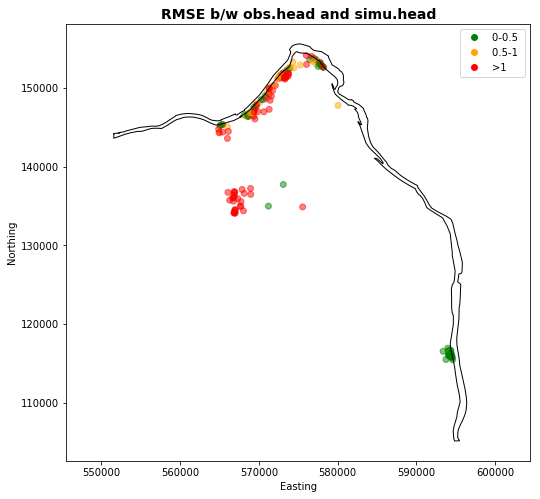

In [30]:
%matplotlib inline
def colorcode(value):
    color = []
    for ivalue in value:
        if ivalue <= 0.5 :
            icolor = 'green'
        elif ivalue <= 1 :
            icolor = 'orange'
        else:
            icolor = 'red'
        color.append(icolor)
    return color   

fig, ax1 = plt.subplots(1, 1)

river_geometry.plot(x = 'x', y= 'y', ax=ax1, style='-k', lw=1, legend= False)

plt.scatter(RMSE_df_sub['Easting'].values, RMSE_df_sub['Northing'].values, \
            color= colorcode(RMSE_df_sub.RMSE), marker= 'o', edgecolors = 'face',\
#             s = RMSE_df_sub.RMSE*5, 
            alpha = 0.5)

# # add label for points
# for i, txt in enumerate(RMSE_df_sub.index):
#     ax1.annotate(txt, (RMSE_df_sub['Easting'].values[i], RMSE_df_sub['Northing'].values[i]))

ax1.set_xlim([550000, 600000])
ax1.set_ylabel('Northing')
ax1.set_xlabel('Easting')
ax1.set_title('RMSE b/w obs.head and simu.head', fontweight = 'bold', fontsize = 14)
ax1.set_aspect("equal", "datalim")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='0-0.5 ',
                          markerfacecolor='g', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='0.5-1 ',
                          markerfacecolor='orange', markersize=8),
                    Line2D([0], [0], marker='o', color='w', label='>1 ',
                          markerfacecolor='r', markersize=8),
                    ]
ax1.legend(handles=legend_elements, loc='best')

# ax1.legend(handles=legend_elements, loc='best')
fig.tight_layout()
fig.set_size_inches(8, 8)

In [31]:
fname = fig_simu_obs_wl + 'RMSE.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

### interactive map with folium

In [17]:
fname = fig_simu_obs_wl + 'RMSE.csv'
RMSE_df = pd.read_csv(fname)
RMSE_df_sub = RMSE_df[RMSE_df.RMSE < 10].dropna()

FileNotFoundError: File b'/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/HFR_model_100x100x2_new_iniH/simu_obs_wl/RMSE.csv' does not exist

In [ ]:
HFR_map = folium.Map(location=[46.6, -119.5], tiles= 'Stamen Terrain', zoom_start= 10)

df = RMSE_df_sub.copy()
# df = df.head(1)
fg = folium.FeatureGroup(name= 'RMSE b/w simu and obs WL')

def colorcode(ivalue):
    if ivalue <= 0.5 :
        icolor = 'green'
    elif ivalue <= 1 :
        icolor = 'orange'
    else:
        icolor = 'red'
    return icolor 

resolution, width, height = 75, 7, 3

for lat, lon, name, value in zip(df['lat'], df['lon'], df['WellName'], df['RMSE']):
    
    iframe = IFrame('<img src="data:image/png;base64,{}">'.format(base64.b64encode(open(\
                'figures/wl/Well {}_6h_ma_rs.png'.format(name), 'rb').read()).decode()), \
                width=1200, height=750)
    fg.add_child(folium.CircleMarker(location=[lat, lon], 
#                                      popup=folium.Popup(name),
                                     popup = folium.Popup(iframe, max_width=2500),
#                                     radius = (value - df['median'].min())/(df['median'].max()-df['median'].min())*10,
                                     radius = 5,
                                     color = colorcode(value),
#                                     fill = False,
#                                     fill_color = 'crimson',
                                    ))  
## add legend to map
url = "https://github.com/pshuai88/notebook/raw/master/figures/RMSE_legend.png"
FloatImage(url, bottom = 75, left= 75).add_to(HFR_map)

# FloatImage(iframe, bottom = 75, left= 75).add_to(fg)
    
HFR_map.add_child(fg)
HFR_map.add_child(folium.LayerControl())

In [ ]:
HFR_map.save('figures/RMSE_popup.html')

## plot well tracer vs SpC

In [ ]:

selected_chemical = 'Specific Conductance'
iobs_chemical = GW_chem[GW_chem.loc[:,'Chemical'] == selected_chemical].copy()
iobs_chemical.rename(columns={'Concentration': 'Spc'}, inplace = True)

**export tracer to .csv file**

In [ ]:
well_list = ['199-H1-7', '199-H3-25', '199-H3-5', '199-H3-7']
for iwell in well_list[0:]:
    print(iwell)
    itracer_df = well_data_df[iwell, 'Total Tracer [M]', 'flux_ave_tracer'].copy()
    idf = pd.DataFrame({'DateTime':real_time_6h, 'tracer_conc':itracer_df.values})
    fname = out_dir + iwell + '_tracer.csv'
    idf.to_csv(fname)

In [ ]:
%matplotlib inline 

spc_map_well = []
for iwell in obs_well_names[:]:
#     iwell = '399-3-9'
#     iwell = '399-2-33'
    print(iwell)
    iobs_data_df = pd.DataFrame()
    
    itracer_df = well_data_df[iwell, 'Total Tracer [M]', 'flux_ave_tracer'].copy()
    
    # read obs.head
    if iwell in SFA_well['WellName'].unique():
        iobs_data_df = SFA_well[SFA_well.loc[:, 'WellName'] == iwell].copy()
        iobs_data_df['Spc'] = iobs_data_df['Spc']*1000 # convert ms/cm to us/cm

    elif iwell in iobs_chemical['WellName'].unique():
        iobs_data_df = iobs_chemical[iobs_chemical.loc[:, 'WellName'] == iwell].copy() 

    else:
        print('No spc data for well ' + iwell)
        continue
        
    iobs_data_df = iobs_data_df.drop_duplicates('DateTime', keep='first') \
                                .sort_values(by = 'DateTime').set_index('DateTime', drop=False).sort_index()
    # filter wells outside of dates
    iobs_data_df = iobs_data_df[(iobs_data_df['DateTime'] >= datetime.date(2011, 1, 1)) \
                                & (iobs_data_df['DateTime'] <= datetime.date(2016, 1, 1))]   
    
    if iobs_data_df['Spc'].count() > 10 and iobs_data_df['Spc'].isnull().all() == False and itracer_df.max()>= 0.1:   
        spc_map_well.append(iwell)
        # find closest mass1 location
        iwell_easting = well_screen.loc[iwell, 'Easting']
        iwell_northing = well_screen.loc[iwell, 'Northing']
        dist = np.sqrt((mass1_coord['Easting']- iwell_easting)**2 + (mass1_coord['Northing']- iwell_northing)**2)
        mass_id = mass1_coord.loc[np.argmin(dist), 'Mass_ID']

        datum_files = glob.glob(fname_river_bc_6h + "Datum*.txt")
        datum_files = natsorted(datum_files) 

        for ifile in datum_files:
            if '_' + str(mass_id) in ifile:
                river_stage = pd.read_table(ifile, sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
            elif mass_id == 333:
                river_stage = pd.read_table(datum_files[-1], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

        river_stage.time = batch_delta_to_time(date_origin, river_stage.time.astype(np.float64), "%Y-%m-%d %H:%M:%S", "seconds")
        river_stage['time'] = river_stage['time'].apply(pd.to_datetime)  
        river_stage = river_stage[(river_stage['time'] >= datetime.date(2011, 1, 1)) \
                            & (river_stage['time'] <= datetime.date(2016, 1, 1))]   
        
        # find the mode of frequecy (in sec)
        res = iobs_data_df['DateTime'].diff().dt.seconds.value_counts().index[0]
        val = iobs_data_df['DateTime'].diff().dt.seconds.value_counts().values[0]
        if res <= 86400 and val >=100 :    
            style = '-k'
        else:
            style = '-ko'
#     iobs_data_df['Spc'] = (iobs_data_df['Spc'] - spc_u_data['Spc'].min()) / (spc_u_data['Spc'].max() - spc_u_data['Spc'].min())
#     iobs_data_df['Spc'] = (iobs_data_df['Spc'] - well_data['Spc'].min()) / (well_data['Spc'].max() - well_data['Spc'].min())


        ## ============= plot tracer vs SpC===================##
#         fig, ax1 = plt.subplots(1, 1)  # short hand
        fig = plt.figure()
        ax1 = fig.add_subplot(3, 1, 1)
        
#         river_stage.plot(x= 'time', y= 'wl', legend=False, ax=ax1, color = 'gray' , lw = 1, rot = 0, alpha = 0.5)
        ax1.plot(river_stage.time, river_stage.wl, color = 'gray' , lw = 1, alpha = 0.5)        
        ax1.set_xlim([real_time_6h[0], real_time_6h[-1]])
        ax1.set_ylabel('River Stage (m)', color='k')
#         ax1.legend()
        
        ax2 = fig.add_subplot(3, 1, (2,3), sharex = ax1)
#         plt1 = iobs_data_df.plot(x='DateTime', y='Spc', style = style, lw = 1, ms = 3, \
#                                  mfc='None' , markeredgewidth= 0.5, color='k', legend=False, ax=ax2, rot=0)
        ax2.plot(iobs_data_df.DateTime, iobs_data_df.Spc, style, lw = 1, ms = 3, \
                                 mfc='None' , markeredgewidth= 0.5, color='k')
        ax2.set_xlim([real_time_6h[0], real_time_6h[-1]])

        ax2.set_ylabel(r'SpC ($\mu$s/cm)', color='k')
        ax2.set_xlabel('')
        ax2.tick_params('y', colors='k')
#         ax2.legend(['SpC'], frameon=False,
#                    loc='lower left', bbox_to_anchor=(0, 0.95))
        

        # create another y-scale using the same x axis
        ax3 = ax2.twinx()
        plt2 = ax3.plot(real_time_6h, itracer_df.values, 'r-', lw = 1)

        
        ax3.set_ylim([0, 1])
#         ax2.set_xlim([real_time_6h[0], real_time_6h[-1]])
        ax3.set_ylabel('tracer (-)', color='r')
        ax3.tick_params('y', colors='r')
#         ax3.legend(['tracer'], frameon=False,
#                    loc='lower left', bbox_to_anchor=(0, 0.90))
        
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.minorticks_off()
        plt.suptitle('Well ' + iwell, fontweight = 'bold', fontsize = 14)
        fig.tight_layout()
        fname = fig_tracer_spc + 'Well ' + iwell + '_spc_10'
        fig.set_size_inches(8, 5)
        fig.savefig(fname, dpi=300)
        plt.close(fig)

### show wells using folium

In [ ]:
df = pd.read_csv(fname_GW_spc_summary, index_col='WellName')

df = df.loc[spc_map_well]

In [ ]:
HFR_map = folium.Map(location=[46.6, -119.5], tiles= 'Stamen Terrain', zoom_start= 10)

# df = df.head(1)
fg = folium.FeatureGroup(name= 'Tracer vs SpC')

def colorcode(ivalue):
    if ivalue <= 100 :
        icolor = 'green'
    elif ivalue <= 300 :
        icolor = 'orange'
    elif ivalue <= 500 :
        icolor = 'purple'
    else:
        icolor = 'red'
    return icolor   

resolution, width, height = 75, 7, 3
## add popup image 
# png = 'figures/{}_map_legend.png'.format('nitrate')
# encoded = base64.b64encode(open(png, 'rb').read()).decode()
# html = '<img src="data:image/png;base64,{}">'.format
# iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)




for lat, lon, name, value in zip(df['latitude'], df['longitude'], df.index, df['median']):
    
    iframe = IFrame('<img src="data:image/png;base64,{}">'.format(base64.b64encode(open(\
                'figures/spc/Well {}_spc_10.png'.format(name), 'rb').read()).decode()), \
                width=1200, height=750)
    fg.add_child(folium.CircleMarker(location=[lat, lon], 
#                                      popup=folium.Popup(name),
                                     popup = folium.Popup(iframe, max_width=2500),
#                                     radius = (value - df['median'].min())/(df['median'].max()-df['median'].min())*10,
                                     radius = 5,
                                     color = colorcode(value),
#                                     fill = False,
#                                     fill_color = 'crimson',
                                    ))  
## add legend to map
HFR_map.save('figures/RMSE_popup.html')
url = "https://github.com/pshuai88/notebook/raw/master/figures/spc_legend.png"
FloatImage(url, bottom = 75, left= 75).add_to(HFR_map)

# FloatImage(iframe, bottom = 75, left= 75).add_to(fg)
    
HFR_map.add_child(fg)
HFR_map.add_child(folium.LayerControl())

In [ ]:
HFR_map.save('figures/spc_popup.html')

### show wells using mplleaflet

In [ ]:
# %matplotlib inline

ichemical = pd.read_csv(fname_GW_NO3_summary)
medianConc = ichemical['median'].values /1000  # convert ug/L to mg/L

geometry = [Point(xy) for xy in zip(ichemical.longitude, ichemical.latitude)]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(ichemical, crs = crs, geometry = geometry)

def colorcode(value):
    color = []
    for ivalue in value:
        if ivalue <= 10 :
            icolor = 'green'
        elif ivalue <= 30 :
            icolor = 'orange'
        elif ivalue <= 50 :
            icolor = 'purple'
        else:
            icolor = 'red'
        color.append(icolor)
    return color 

ax = geo_df.plot(column = 'median', color = colorcode(medianConc))

# ax.legend(handles=legend_elements, loc='best')

In [ ]:
# tile option: cartodb_positron, esri_worldtopo, 
tiles = ['cartodb_positron', 'esri_aerial', 'esri_worldtopo', 'mapbox bright']
mplleaflet.show(fig=ax.figure, crs=geo_df.crs, tiles = tiles[1], path= 'nitrate_map_aerial.html')

### show well location using Leaflet

create GEOjson file to load into leaflet

In [ ]:
nitrate_coord_agg = pd.read_csv(fname_GW_NO3_coord)

# create GEOjson file to load into leaflet
json_result_string = nitrate_coord_agg.to_json(
    orient='records', 
    double_precision=12,
    date_format='iso'
)
json_result = json.loads(json_result_string)

geojson = {
    'type': 'FeatureCollection',
    'features': []
}
for record in json_result:
    geojson['features'].append({
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [record['longitude'], record['latitude']],  # GeoJSON need coord in long and lat order
        },
        'properties': record,
    })

# save json file
with open(fname_GW_NO3_geojson, 'w') as f:
    f.write(json.dumps(geojson, indent=2))

overlay wells on map

In [ ]:
m = Map(center=(46.6, -119.5), zoom=10, layout = dict(width = '600px', height = '600px'),  basemap=basemaps.Esri.WorldImagery)

In [ ]:
label = ipyw.Label(layout=ipyw.Layout(width='100%'))

In [ ]:
with open(fname_GW_NO3_geojson, 'r') as f:
    data = json.load(f)
# for feature in data['features']:
#     feature['properties']['style'] = {
#         'color': 'grey',
#         'weight': 1,
#         'fillColor': 'grey',
#         'fillOpacity': 0.5
#     }
layer = GeoJSON(data=data, name='Nitrate')

def hover_handler(event=None, id=None, properties=None):
    label.value = properties['WellName']

layer.on_hover(hover_handler)

m.add_layer(layer)
# Adding the control# Addin 
m.add_control(LayersControl())

In [ ]:
# m

# calculate simulated head using H5 output
We can calculate total head by $$H = h + z, (h = (P-P_{atm})/\gamma/g)$$  
which $h$ has shape of **(100, 300, 300)**, and $z$ has shape of **(100,)**. To use broadcasting rule, the dimension of two arrays must match or either one has $dim = 1$. In this case, $z$ is reshaped to **(100, 1, 1)**. that is $$ H(100, 300, 300) = h(100,300,300) + z(100, 1, 1) $$


note: when importing hdf5 dataset of dimension **(nx, ny, nz)**, the shape of numpy array will be **(nx, ny, nz)**. The correct logical shape in numpy would need to change to **(nz, ny, nx)** by using `np.swapaxes(0, 2)`.

## Using interpolation to get well simu data at given location
notes about using scipy.interpolate:
* **`interpolate.Rbf`** performs best for irregular dataset compared to `interpolate.interp2d` and `interpolate.griddata` and can do both interpolation and extrapolation, however, it is **extremely slow** for large dataset. Note: __`.Rbf` method could not have duplicate in points, otherwise it will return sigular matrix__ (see this [post](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy))
* **`interpolate.RectBivariateSpline`** is fast for structured grid, however, it will return NaN if there is missing data in the inputs. A work around is to replace those missing data with 0 or -9999. After interpolation, set those missing data to NaN again. (see this [post](https://stackoverflow.com/questions/15485343/bivariate-structured-interpolation-of-large-array-with-nan-values-or-mask)) (_note: this method can create some erratic numbers (negative concentration)_)
* **`interpolate.griddata`** interpolate scatter points to a regular grid. It does not perform extrapolation. Need to test its performance against large dataset.

**note:** this method won't work where there are inactive cells (NA) surrounding wells. In this case, river shore wells yield underestimated water level using interpolation.

Initialize arrays...
Be careful using `np.empty()`, it will generate random number in the array.

In [ ]:
well_simu_head = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store simu.head at obs.wells
well_xflux = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store abs.flux at obs.wells
well_yflux = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store abs.flux at obs.wells
well_ave_tracer = np.zeros((len(time_index), len(well_screen.index))) # store flux-average tracer conc.
well_tracer = np.zeros((len(time_index), nz, len(well_screen.index))) # initialize array to store tracer conc. at obs.wells

# create index for well screen intervals range within model domain
interval_index = np.where((z >= np.min(well_screen['SCREEN_ELEV_BOTTOM'])) \
                          & (z <= np.max(well_screen['SCREEN_ELEV_TOP'])))
interval_index = np.asarray(interval_index).flatten()

In [ ]:
# loop over time step
for itime in np.arange(len(time_index))[:]:
#         ipdb.set_trace()
    print(time_index[itime])
    real_itime = batch_delta_to_time(date_origin, [float(time_index[itime][7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = str(real_itime)
    print(real_itime, type(real_itime))
    # read pressure
    temp_pressure = np.asarray(list(input_h5[time_index[itime]]["Liquid_Pressure [Pa]"])).swapaxes(0,2)
    temp_pressure[temp_pressure == 0] = np.nan # replace 0 (inactive cell pressure) with nan to avoid calculations

    # convert liquid_pressure to pressure head
    temp_head = (temp_pressure - P_atm) / rho / g_const
    # reshape z to use broadcasting rule
    z_reshape = z.reshape(nz, 1, 1)
    # total head  = presure head + elevation head
    temp_total_head = temp_head + z_reshape

    # create a copy of total_head and replace nan with 0
    total_head_copy = temp_total_head.copy()
    total_head_copy = np.nan_to_num(total_head_copy) # replace nan with 0 for interpolation
    
    # calculate ave. tracer conc. at wells
    xflux = np.asarray(list(input_h5[time_index[itime]]['Liquid X-Flux Velocities'])).swapaxes(0,2) 
    yflux = np.asarray(list(input_h5[time_index[itime]]['Liquid Y-Flux Velocities'])).swapaxes(0,2)

    
    temp_tracer = np.asarray(list(input_h5[time_index[itime]]['Total_Tracer [M]'])).swapaxes(0,2)
#     temp_tracer[temp_tracer == 0] = np.nan
    # interpolate head at each iz layer
    for iz in interval_index:
        f_head = interpolate.RectBivariateSpline(y, x, total_head_copy[iz, :,:])
        f_xflux = interpolate.RectBivariateSpline(y, x_grids[1:-1], xflux[iz, :,:]) #x-flux shape is different from y-flux shape
        f_yflux = interpolate.RectBivariateSpline(y_grids[1:-1], x, yflux[iz, :,:])        
        f_tracer = interpolate.RectBivariateSpline(y, x, temp_tracer[iz, :,:])
#         f_tracer = interpolate.SmoothBivariateSpline(yy.flatten(), xx.flatten(), temp_tracer[iz, :,:].flatten())        
        # evaluate at well points
        well_simu_head[itime, iz, :] = f_head.ev(well_screen['Northing'], well_screen['Easting']) 

        well_xflux[itime, iz, :] = f_xflux.ev(well_screen['Northing'], well_screen['Easting'])
        well_yflux[itime, iz, :] = f_yflux.ev(well_screen['Northing'], well_screen['Easting'])
        
        well_tracer[itime, iz, :] = f_tracer.ev(well_screen['Northing'], well_screen['Easting']) # has negative value?
    
    well_tracer[well_tracer < 0] = np.nan     
    # calculate flux averageing tracer at each well
    for iwell in well_screen.index[:]:
    #     iwell = '399-1-10A'
#         print(iwell)
        iwell_abs_flux = []
        iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
        iwell_interval_index = np.where((z > well_screen.loc[iwell, 'SCREEN_ELEV_BOTTOM']) \
                                        & (z < well_screen.loc[iwell, 'SCREEN_ELEV_TOP']))
        iwell_interval_index = np.asarray(iwell_interval_index).flatten()
        
        iwell_abs_flux = np.sqrt(well_xflux[itime, iwell_interval_index, iwell_screen_index]**2 + \
                                well_yflux[itime, iwell_interval_index, iwell_screen_index]**2)
        iwell_abs_flux = np.asarray(iwell_abs_flux).flatten()
        well_ave_tracer[itime, iwell_screen_index] = np.sum(iwell_abs_flux*well_tracer[itime, iwell_interval_index, \
                                                                                       iwell_screen_index])/np.sum(iwell_abs_flux)

dump files using `pickle.dump` and load files using `pickle.load`

In [ ]:
# saving objects
with open(fname_well_simu_data_pk, "wb") as f:
    pickle.dump((well_simu_head, well_xflux, well_yflux, well_tracer, well_ave_tracer), f)
# # loading objects    
# with open(fname_well_simu_data_pk, "rb") as f:
#     well_simu_head, well_xflux, well_yflux, well_tracer, well_ave_tracer = pickle.load(f)

## plot well simu vs obs head

In [ ]:
%matplotlib inline 
for iwell in well_screen.index[17:]:
#     iwell = '399-2-10'
    print(iwell)
    iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
    iwell_interval_index = np.where((z >= well_screen.loc[iwell, 'SCREEN_ELEV_BOTTOM']) \
                                    & (z <= well_screen.loc[iwell, 'SCREEN_ELEV_TOP']) \
                                   )
    iwell_interval_index = np.asarray(iwell_interval_index).flatten()
    # well head is taken at the lowest screen interval--iwell_interval_index[0]
    
    if iwell_interval_index.size > 0:
        isimu_head = well_simu_head[:, iwell_interval_index[0], iwell_screen_index]
        isimu_head = isimu_head.reshape(isimu_head.shape[0])
    
    # read obs.head
    if iwell in SFA_well['WellName'].unique():
        iobs_head_df = SFA_well[ SFA_well.loc[:, 'WellName'] == iwell].copy()
        iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    elif iwell in HEIS_auto['WellName'].unique():
        iobs_head_df = HEIS_auto[ HEIS_auto.loc[:, 'WellName'] == iwell].copy()
        iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    elif iwell in HEIS_manual['WellName'].unique():
        iobs_head_df = HEIS_manual[ HEIS_manual.loc[:, 'WellName'] == iwell].copy()
        iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    else:
        iobs_head_df = pd.DataFrame()
        print('No well obs data available for' + iwell)
   
    if iobs_head_df.size > 0:
        ##================= plot simu vs obs head========================##
        # fig = plt.figure() # open a canvas
        # ax = fig.add_subplot(1, 1, 1) # create 1st subplot on a 1x1 grid
        fig, ax = plt.subplots(1, 1) # short hand

        # plt.plot(iobs_datetime.iloc[:], iobs_head_df['WL'], 'k-')
        # plt.plot(iobs_head_df['DateTime'], iobs_head_df['WL'])


        iobs_head_df.plot(x= 'DateTime', y= 'WL', color='k', legend=False, ax=ax, 
                         figsize = (8, 5), title = 'Well ' + iwell,
                         rot = 0)
        plt.plot(real_time_index, isimu_head, 'r-')

        ax.set_xlim([real_time_index[0], real_time_index[-1]])
#         ax.set_ylim([104.5, 108.5])
        ax.set_ylabel('Water Level (m)')
        ax.set_xlabel('')
        ax.legend(['obs.head', 'simu.head'], frameon = False)

        fig.tight_layout()
        fname = fig_simu_obs_wl + 'Well ' + iwell 
        fig.savefig(fname , dpi=300)
        plt.close(fig)
 

## plot well tracer vs SpC

In [ ]:
%matplotlib inline 

selected_chemical = 'Specific Conductance'
iobs_chemical = GW_chem[GW_chem.loc[:,'Chemical'] == selected_chemical].copy()
iobs_chemical.rename(columns={'Chemical': 'Spc'}, inplace = True)

for iwell in well_screen.index[:]:
#     iwell = '399-1-10A'
    print(iwell)
    iobs_data_df = pd.DataFrame()
    iwell_screen_index = np.asarray(np.where(well_screen.index == iwell)).flatten()
    
    itracer = well_ave_tracer[:, iwell_screen_index]
    
    
    # read obs.head
#     iobs_data_df = spc_u_data[ spc_u_data.loc[:, 'WellName'] == iwell].copy()
    if iwell in SFA_well['WellName'].unique():
        iobs_data_df = SFA_well[SFA_well.loc[:, 'WellName'] == iwell].copy()
        iobs_data_df['Spc'] = iobs_data_df['Spc']*1000
        iobs_data_df['DateTime'] = iobs_data_df['DateTime'].apply(pd.to_datetime)
    elif iwell in iobs_chemical['WellName'].unique():
        iobs_data_df = iobs_chemical[iobs_chemical.loc[:, 'WellName'] == iwell].copy()        
    else:
        print('No spc data for well ' + iwell)

#     iobs_data_df['Spc'] = (iobs_data_df['Spc'] - spc_u_data['Spc'].min()) / (spc_u_data['Spc'].max() - spc_u_data['Spc'].min())
#     iobs_data_df['Spc'] = (iobs_data_df['Spc'] - SFA_well['Spc'].min()) / (SFA_well['Spc'].max() - SFA_well['Spc'].min())
    if iobs_data_df.size > 0 and iobs_data_df['Spc'].isnull().all() == False:

        ## ============= plot tracer vs SpC===================##
        fig, ax1 = plt.subplots(1, 1)  # short hand

        plt1 = iobs_data_df.plot(x='DateTime', y='Spc', linestyle='-',marker='o', \
                                 mfc='none' , markeredgewidth= 0.5, color='k', legend=False, ax=ax1, rot=0)

    #         ax1.title('Well ' + iwell)
        ax1.set_xlim([real_time_index[0], real_time_index[-1]])
    #         ax1.set_ylim([0, 1])
    #         ax.set_ylim([104.5, 108.5])
        ax1.set_ylabel(r'SpC ($\mu$s/cm)', color='k')
        ax1.set_xlabel('')
        ax1.tick_params('y', colors='k')
        ax1.legend(['SpC'], frameon=False,
                   loc='lower left', bbox_to_anchor=(0, 1))
        plt.suptitle('Well' + iwell)

        # create another y-scale using the same x axis
        ax2 = ax1.twinx()
        plt2 = ax2.plot(real_time_index, itracer, 'r-')
        ax2.set_ylim([0, 1])
        ax2.set_ylabel('tracer (-)', color='r')
        ax2.tick_params('y', colors='r')
        ax2.legend(['tracer'], frameon=False,
                   loc='lower right', bbox_to_anchor=(1, 1))


        fig.tight_layout()
        fname = fig_tracer_spc + 'Well ' + iwell + '_spc'
        fig.set_size_inches(8, 5)
        fig.savefig(fname, dpi=300)
        plt.close(fig)

## plot well tracer vs NO3

In [ ]:
%matplotlib inline 

selected_chemical = 'Nitrate'
iobs_chemical = GW_chem[GW_chem.loc[:,'Chemical'] == selected_chemical].copy()

box_x = [577000, 581000]
box_y = [149000, 153000]

for iwell in iobs_chemical['WellName'].unique()[:]:
#     iwell = '52-D'
    print(iwell)
    iobs_data_df = iobs_chemical[iobs_chemical.loc[:, 'WellName'] == iwell].copy()
    if (iobs_data_df['EASTING'].unique() >= box_x[0] and \
                        iobs_data_df['EASTING'].unique() <= box_x[1] and \
                        iobs_data_df['NORTHING'].unique() >= box_y[0] and \
                        iobs_data_df['NORTHING'].unique() <= box_y[1]):
        if iobs_data_df.size >0:
            fig, ax1 = plt.subplots(1, 1)  # short hand

            plt1 = iobs_data_df.plot(x='DateTime', y='Concentration', linestyle='-',marker='o', \
                                     mfc='none' , markeredgewidth= 0.5, color='k', legend=False, ax=ax1, rot=0)

        #         ax1.title('Well ' + iwell)
    #         ax1.set_xlim([real_time_index[0], real_time_index[-1]])
        #         ax1.set_ylim([0, 1])
        #         ax.set_ylim([104.5, 108.5])
            unit = iobs_data_df['Unit'].unique()
            ax1.set_ylabel('Nitrate ' + '(' + unit[0] + ')', color='k')
            ax1.set_xlabel('')
            ax1.tick_params('y', colors='k')
            ax1.legend(['Nitrate'], frameon=False,
                       loc='lower left', bbox_to_anchor=(0, 1))
            plt.suptitle('Well ' + iwell)

    #         # create another y-scale using the same x axis
    #         ax2 = ax1.twinx()
    #         plt2 = ax2.plot(real_time_index, itracer, 'r-')
    #         ax2.set_ylim([0, 1])
    #         ax2.set_ylabel('tracer (-)', color='r')
    #         ax2.tick_params('y', colors='r')
    #         ax2.legend(['tracer'], frameon=False,
    #                    loc='lower right', bbox_to_anchor=(1, 1))


            fig.tight_layout()
            fname = fig_nitrate + 'Well ' + iwell + '_NO3'
            fig.set_size_inches(8, 5)
            fig.savefig(fname, dpi=300)
            plt.close(fig)




# plot groundwater level contour 

**note: for plotting contour surface using `plt.contour(X,Y,Z)`, Z must be shape of (ny, nx)**

In [ ]:
iz = interval_index[-7]
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
# plot contour
cf1 = ax1.contourf(x, y, temp_total_head[iz, :,:],
                   cmap=plt.cm.jet,
                   vmin=100,
                   vmax=130,
                   extend="both",
                   levels=np.arange(100, 130.1, 1)
                   )
# plot contour lines
cf2 = plt.contour(cf1, colors='grey', levels=np.arange(100, 130.1, 1))
ax1.set_aspect("equal", "datalim")

plt.plot(well_screen['Easting'], well_screen['Northing'], 'ko')
plt.clabel(cf2, inline = True, fmt = '%3.0d', fontsize = 10)
# plt.xlim(42000, 43000)
# plt.ylim(9000, 14000)

In [ ]:
        fig.savefig(fig_name, dpi=600, transparent=True)
        plt.close(fig)
input_h5.close()